In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import re
import warnings
warnings.filterwarnings('ignore')

print("All packages loaded!")

All packages loaded!


In [13]:
#2 LOAD DATA
df = pd.read_csv('twcs.csv')
print(f"\nLoaded {len(df):,} rows")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())



Loaded 2,811,774 rows
Columns: ['tweet_id', 'author_id', 'inbound', 'created_at', 'text', 'response_tweet_id', 'in_response_to_tweet_id']

First few rows:
   tweet_id   author_id  inbound                      created_at  \
0         1  sprintcare    False  Tue Oct 31 22:10:47 +0000 2017   
1         2      115712     True  Tue Oct 31 22:11:45 +0000 2017   
2         3      115712     True  Tue Oct 31 22:08:27 +0000 2017   
3         4  sprintcare    False  Tue Oct 31 21:54:49 +0000 2017   
4         5      115712     True  Tue Oct 31 21:49:35 +0000 2017   

                                                text response_tweet_id  \
0  @115712 I understand. I would like to assist y...                 2   
1      @sprintcare and how do you propose we do that               NaN   
2  @sprintcare I have sent several private messag...                 1   
3  @115712 Please send us a Private Message so th...                 3   
4                                 @sprintcare I did.             

In [14]:
#3 FILTER CUSTOMER MESSAGES
# Keep only customer messages (inbound = TRUE)
if 'inbound' in df.columns:
    df_customer = df[df['inbound'] == True].copy()
    print(f"Found {len(df_customer):,} customer messages")
else:
    df_customer = df.copy()
    print("  No 'inbound' column - using all messages")

# Clean text
df_customer = df_customer[df_customer['text'].notna()].copy()
print(f" {len(df_customer):,} messages with text")

Found 1,537,843 customer messages
 1,537,843 messages with text


In [15]:
#4 AUTO-LABEL MESSAGES
def auto_label(text):
    """Automatically categorize tweets using keywords"""
    if pd.isna(text):
        return 'Unknown'

    text = str(text).lower()

    # Count keyword matches
    billing_words = ['charge', 'payment', 'bill', 'refund', 'subscription',
                     'invoice', 'price', 'cost', 'paid', 'card', 'plan']

    technical_words = ['crash', 'error', 'bug', 'broken', 'not working', 'slow',
                       'loading', 'login', 'down', 'sync', 'app', 'website',
                       'install', 'update', '404', '500', 'timeout']

    account_words = ['account', 'password', 'email', 'username', 'profile',
                     'verify', 'settings', 'delete', 'change', 'reset',
                     'authentication', 'security', 'privacy']

    billing_score = sum(1 for word in billing_words if word in text)
    technical_score = sum(1 for word in technical_words if word in text)
    account_score = sum(1 for word in account_words if word in text)

    # Return category with highest score
    scores = {
        'Billing': billing_score,
        'Technical': technical_score,
        'Account': account_score
    }

    max_score = max(scores.values())
    if max_score == 0:
        return 'Unknown'

    return max(scores, key=scores.get)

# Apply auto-labeling
print("Auto-labeling messages...")
df_customer['category'] = df_customer['text'].apply(auto_label)

# Show distribution
print("\nLabel Distribution:")
for cat, count in df_customer['category'].value_counts().items():
    pct = count / len(df_customer) * 100
    print(f"  {cat:12s}: {count:5,} ({pct:5.1f}%)")

# Show examples
print("\nSample Labeled Messages:")
for cat in ['Billing', 'Technical', 'Account']:
    if cat in df_customer['category'].values:
        sample = df_customer[df_customer['category'] == cat]['text'].iloc[0]
        print(f"\n{cat}: {sample[:100]}...")


Auto-labeling messages...

Label Distribution:
  Unknown     : 998,976 ( 65.0%)
  Technical   : 307,717 ( 20.0%)
  Billing     : 147,356 (  9.6%)
  Account     : 83,794 (  5.4%)

Sample Labeled Messages:

Billing: @115721 Hello Duke, Do you have a copy of your bill? What state are your services located in?
^NHP...

Technical: actually that's a broken link you sent me and incorrect information https://t.co/V4yfrHR8VI...

Account: @sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯...


In [16]:
#5 PREPARE DATA FOR TRAINING
# Remove Unknown labels
df_labeled = df_customer[df_customer['category'] != 'Unknown'].copy()
print(f" Using {len(df_labeled):,} labeled messages for training")

# Get messages and labels
messages = df_labeled['text'].tolist()
labels = df_labeled['category'].tolist()

# Clean text function
def clean_text(text):
    """Remove @mentions, URLs, special characters"""
    text = str(text).lower()
    text = re.sub(r'@\w+', '', text)  # Remove @mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', ' ', text)  # Keep only letters
    text = ' '.join(text.split())  # Remove extra spaces
    return text

# Clean all messages
messages_clean = [clean_text(m) for m in messages]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    messages_clean, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f" Training set: {len(X_train):,} messages")
print(f" Test set: {len(X_test):,} messages")


 Using 538,867 labeled messages for training
 Training set: 431,093 messages
 Test set: 107,774 messages


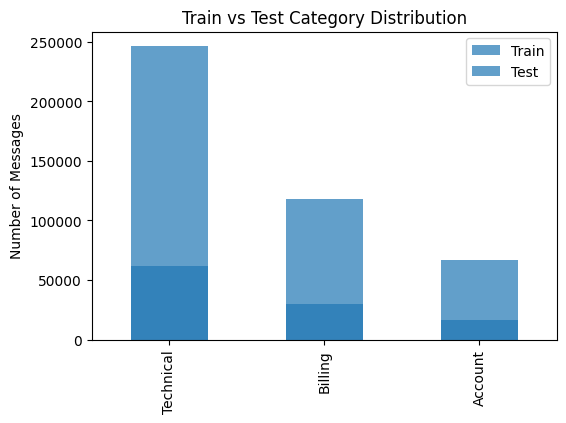

In [17]:
# SIMPLE VISUALIZATION: Train vs Test Distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

train_counts.plot(kind="bar", alpha=0.7, label="Train")
test_counts.plot(kind="bar", alpha=0.7, label="Test")

plt.title("Train vs Test Category Distribution")
plt.ylabel("Number of Messages")
plt.legend()
plt.show()


In [18]:
#6 TRAINING THE MODEL
print("Training classifier...")

# Create pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        stop_words='english'
    )),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

# Train
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTRAINING COMPLETE!")
print(f"Accuracy: {accuracy:.1%}")



Training classifier...

TRAINING COMPLETE!
Accuracy: 94.4%


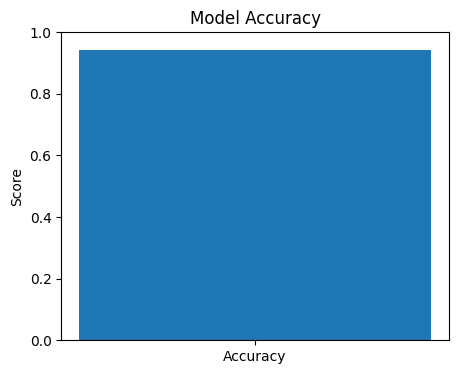

In [19]:
# SIMPLE VISUALIZATION: Accuracy Bar
plt.figure(figsize=(5,4))
plt.bar(["Accuracy"], [accuracy])
plt.ylim(0,1)
plt.title("Model Accuracy")
plt.ylabel("Score")
plt.show()


In [20]:
#7 EVALUATING THE PERFORMANCE
print("\n DETAILED PERFORMANCE REPORT")
print("="*60)

# Classification report
print("\nPer-Category Metrics:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred,
                               labels=['Billing', 'Technical', 'Account'])
conf_df = pd.DataFrame(
    conf_matrix,
    index=['True Billing', 'True Technical', 'True Account'],
    columns=['Pred Billing', 'Pred Technical', 'Pred Account']
)
print(conf_df)

# Show top features
print("\n Most Important Words per Category:")
feature_names = model.named_steps['tfidf'].get_feature_names_out()
coefficients = model.named_steps['classifier'].coef_

for idx, category in enumerate(['Billing', 'Technical', 'Account']):
    top_indices = np.argsort(coefficients[idx])[-8:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"\n{category}: {', '.join(top_words)}")



 DETAILED PERFORMANCE REPORT

Per-Category Metrics:
              precision    recall  f1-score   support

     Account       0.91      0.95      0.93     16759
     Billing       0.98      0.88      0.93     29471
   Technical       0.94      0.97      0.96     61544

    accuracy                           0.94    107774
   macro avg       0.94      0.93      0.94    107774
weighted avg       0.95      0.94      0.94    107774


Confusion Matrix:
                Pred Billing  Pred Technical  Pred Account
True Billing           25988            3102           381
True Technical           541           59886          1117
True Account             102             793         15864

 Most Important Words per Category:

Billing: account, email, change, password, changed, reset, security, emails

Technical: refund, card, paid, charged, charge, price, plane, payment

Account: update, app, website, error, happy, happened, updated, disappointed


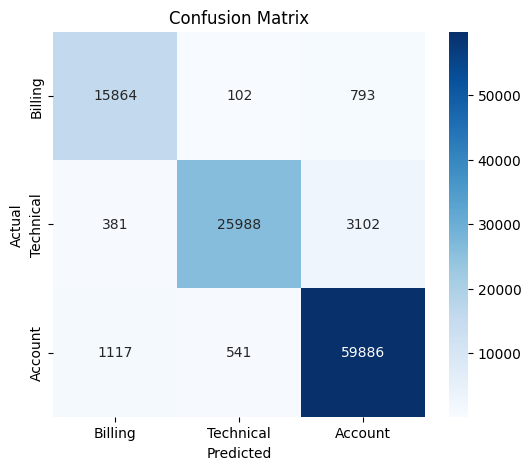

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Billing","Technical","Account"],
            yticklabels=["Billing","Technical","Account"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [22]:
#TEST ON NEW MESSAGES
def predict_category(text):
    """Predict category for a new message"""
    cleaned = clean_text(text)
    category = model.predict([cleaned])[0]
    probabilities = model.predict_proba([cleaned])[0]
    confidence = max(probabilities)

    return {
        'category': category,
        'confidence': confidence,
        'probabilities': dict(zip(['Billing', 'Technical', 'Account'], probabilities))
    }

# Test examples
print("\n TESTING ON NEW MESSAGES")
print("="*60)

test_messages = [
    "I was charged twice this month",
    "The app keeps crashing",
    "How do I change my email?",
    "Can't login to my account",
    "Need a refund for last payment"
]

for msg in test_messages:
    result = predict_category(msg)
    print(f"\nMessage: '{msg}'")
    print(f"{result['category']} ({result['confidence']:.0%} confident)")




 TESTING ON NEW MESSAGES

Message: 'I was charged twice this month'
Billing (100% confident)

Message: 'The app keeps crashing'
Technical (100% confident)

Message: 'How do I change my email?'
Account (100% confident)

Message: 'Can't login to my account'
Technical (99% confident)

Message: 'Need a refund for last payment'
Billing (100% confident)


In [23]:
# TEST MESSAGE

user_text = input("Enter a customer message: ")

prediction = model.predict([user_text])[0]
probabilities = model.predict_proba([user_text])[0]

print("\nPredicted Category:", prediction)
print("\nConfidence Scores:")

for label, prob in zip(model.classes_, probabilities):
    print(f"{label}: {prob:.2%}")


Enter a customer message: The app keeps crashing when I login

Predicted Category: Technical

Confidence Scores:
Account: 0.00%
Billing: 0.00%
Technical: 100.00%
